In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, recall_score,
accuracy_score, plot_roc_curve, roc_auc_score, recall_score,
precision_score, f1_score, classification_report, RocCurveDisplay)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

## About the project

Online clothing retailers can provide shoppers a little more confidence in their purchases by providing size suggestions. As this project, will demonstrate, predicted correct size can be tricky because size selection goes beyong someone's weight, height, and age. Fit preferences also come into play as well as body shape. 

However, in this scenario, our dataset include 119,734 rows providing a shopper's weight (kg), age, height (cm), and size. There are 7 sizes: 'XXS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL'. Our questions here is which classification algorithm can best predict size, can we prodive shoppers with sound predictions?

## About the Data 

The data was found on Kraggle and can be accessed [here](https://www.kaggle.com/datasets/tourist55/clothessizeprediction)

Columns include: weight (kg), age, height (cm), and size

In [2]:
df = pd.read_csv('./data/final_test.csv')

In [3]:
df.head()

,weight,age,height,size
0,62,28.0,172.72,XL
1,59,36.0,167.64,L
2,61,34.0,165.10,M
3,65,27.0,175.26,L
4,62,45.0,172.72,M


In [4]:
df.shape

(119734, 4)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119734 entries, 0 to 119733
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   weight  119734 non-null  int64  
 1   age     119477 non-null  float64
 2   height  119404 non-null  float64
 3   size    119734 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


## EDA

In [84]:
df['size'].value_counts(normalize=True)

M       0.248150
S       0.183106
XXXL    0.178387
XL      0.159679
L       0.146884
XXS     0.083218
XXL     0.000576
Name: size, dtype: float64

In [184]:
df['size'].value_counts()

M       29712
S       21924
XXXL    21359
XL      19119
L       17587
XXS      9964
XXL        69
Name: size, dtype: int64

Somewhat imbalanced dta, with XXL making a small portion of size. Medium is the most common size.

In [10]:
hue_order = ['XXS', 'S', 'M', 'L', 'XL', 'XXL', 'XXXL']

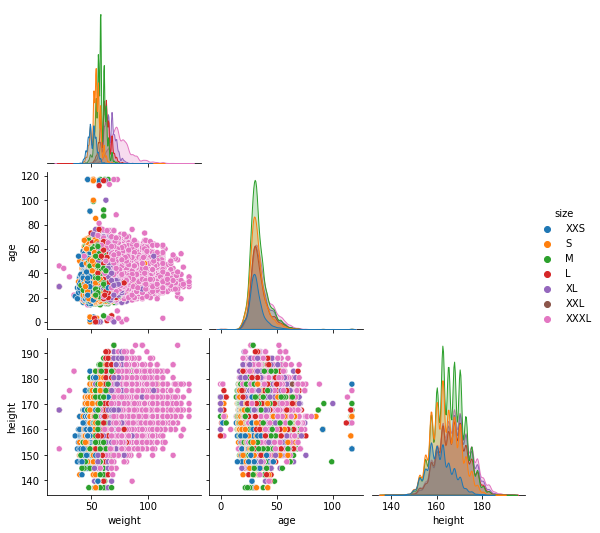

In [11]:
sns.pairplot(df, corner=True, hue='size', hue_order=hue_order);

In [284]:
sns.set_style('darkgrid')

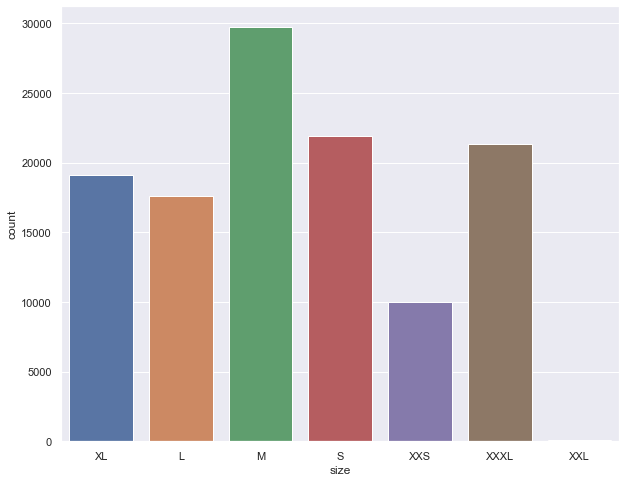

In [286]:
sns.countplot(x=df['size']);

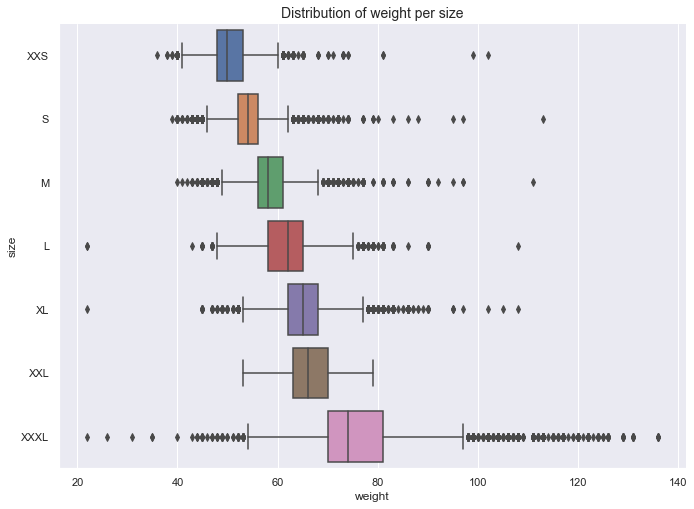

In [183]:
sns.catplot(y='size', x='weight', data=df, kind='box', order=hue_order, height=7, aspect=7/5)
plt.title('Distribution of weight per size', fontdict={'size':14});

The XXXL size has many outliers in the lower and higher end of weight. Perhaps some ladies are wearing XXXL sizes because they want their clothes very loose. Nonetheless, we should keep this data. 

It is not surprising to see that as sizes increase, the distribution of weights do to. We see that for each incresed size, the median weight increases. However, there is a lot of overlap in weights across all sizes. 

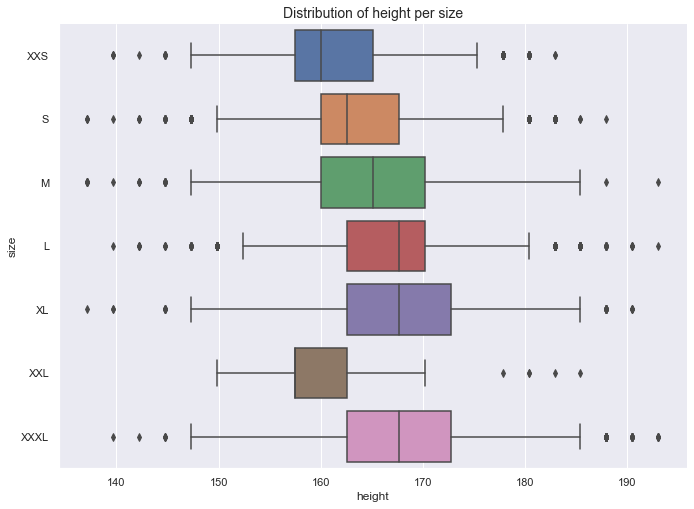

In [65]:
sns.catplot(y='size', x='height', data=df, kind='box', order=hue_order, height=7, aspect=7/5)
plt.title('Distribution of height per size', fontdict={'size':14});

The relationship between heigh and size is not as obvious as the relationship between weight and size. However, the most sizes, the larger the size, the higher the mean height. An exception is size XXL, which has about the same mean height as XXS. 

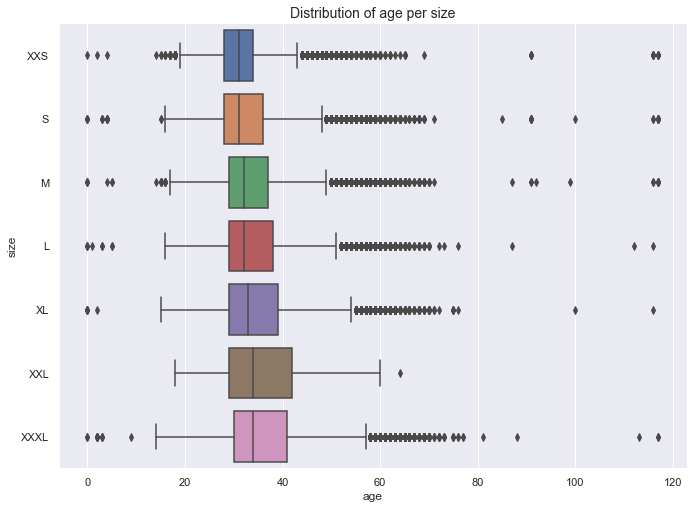

In [64]:
sns.catplot(y='size', x='age', data=df, kind='box', order=hue_order, height=7, aspect=7/5)
plt.title('Distribution of age per size', fontdict={'size':14});

The relationship between size and age is not as obvious as weight or height and size. However, as people age, they tend to increase in size as well. However, we can see that there is a lot of overlap in age among all the different sizes. 

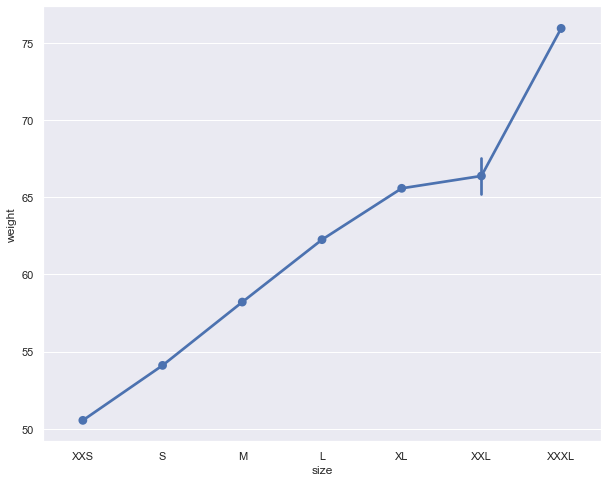

In [291]:
sns.pointplot(x=df['size'], y=df['weight'], order=hue_order);

We see a positive linear relationship between weight and size, although XXL stands out an an anomaly. 

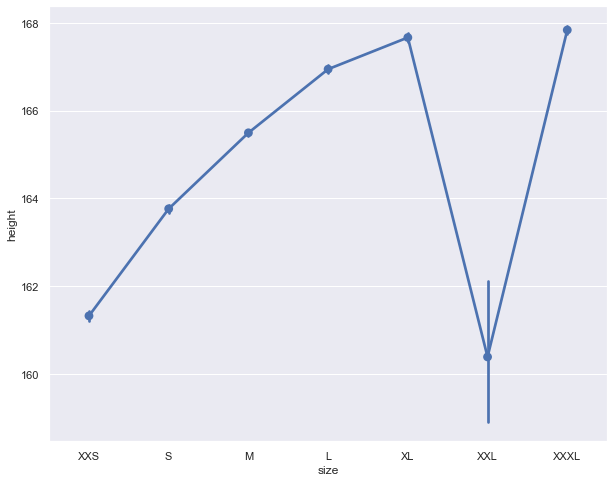

In [292]:
sns.pointplot(x=df['size'], y=df['height'], order=hue_order);

In the pointplot above, we see that the 'mean' for XXL stands out as an anomaly. While average height tends to increase as size goes up, it deeply plunges for XXL. 

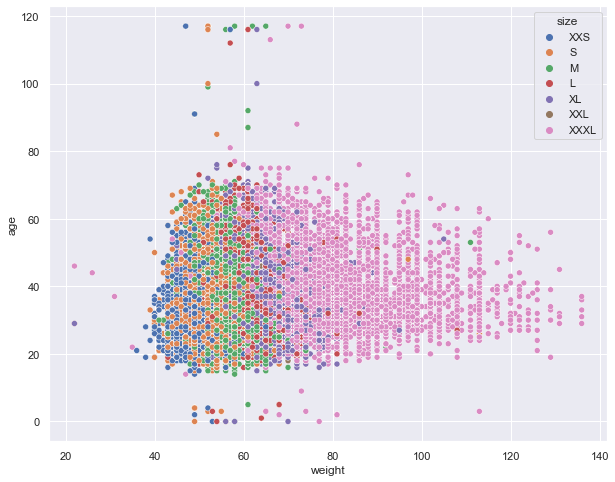

In [207]:
sns.set(rc={'figure.figsize':(10, 8)})
sns.scatterplot(data=df, x='weight', y='age', hue='size', hue_order=hue_order);

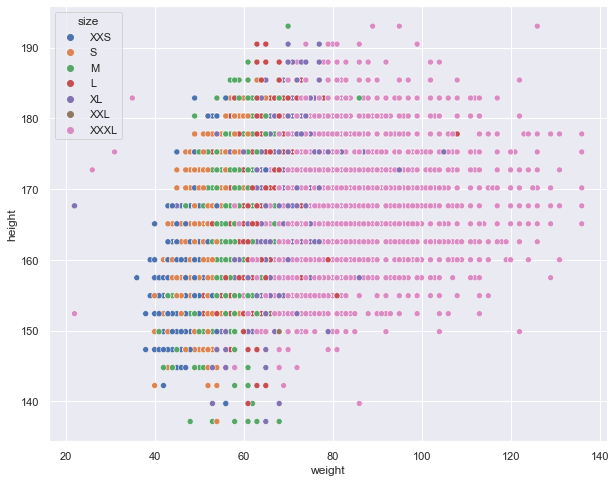

In [208]:
sns.scatterplot(data=df, x='weight', y='height', hue='size', hue_order=hue_order);

The two plots above underscore that size is most influenced by weight than age or height

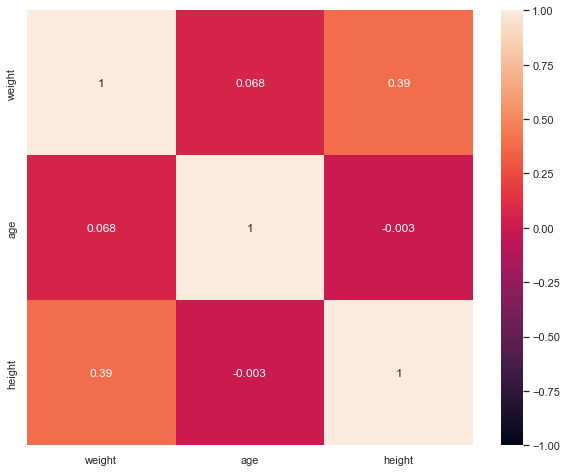

In [73]:
sns.heatmap(df.corr(), vmin=-1, annot=True); 

Age and weight are not as strongly correlated as I may have expected. Weight and Height are positively correlated, that is no surprise

## Preprocessing

In [75]:
import missingno as msno

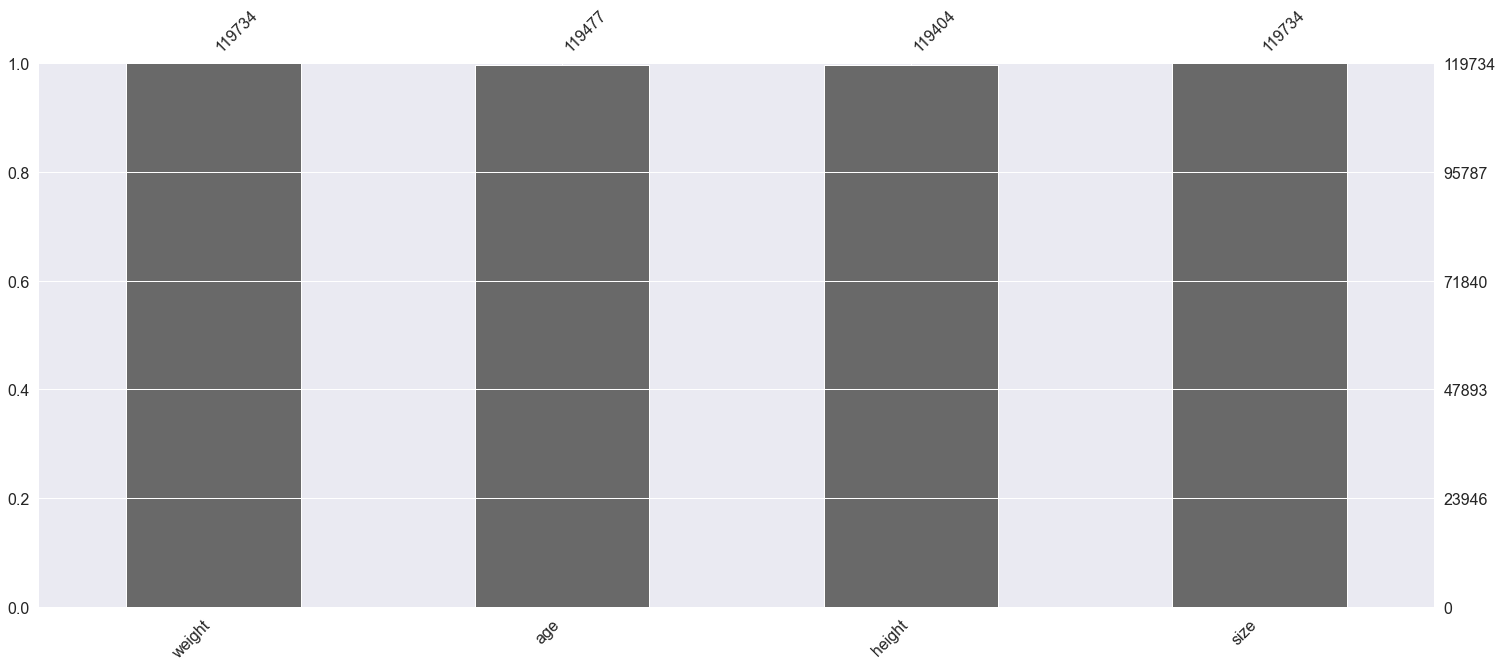

In [ ]:
msno.bar(df);

Two columns have missing values: age and height. Because missing values make a small proportion of the overall data, it could be easy to simply drop all nans. However, I think choose to only drop rows that have both age and height missing. Any other rows with just one nan will be imputed. 

In [78]:
df.dropna(thresh=2, axis=0, inplace=True)

In [81]:
df.isnull().sum()

weight      0
age       257
height    330
size        0
dtype: int64

In [83]:
X = df.drop(columns='size')
y = df['size']

In [85]:
# train-test-split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.25, random_state=29)

In [86]:
knn = KNNImputer()
knn.fit(X_train)
X_train_filled = knn.transform(X_train)
X_test_filled = knn.transform(X_test)

In [ ]:
X_train_filled = pd.DataFrame(X_train_filled, columns = X.columns)
X_test_filled = pd.DataFrame(X_test_filled, columns = X.columns)

### Feature engineering

In the above plots, we saw that both weight and height contribute greatly to size. BMI is a measure that relates both measures. Perhaps our model and improve by adding this feature. 

In [305]:
X_train_filled['bmi'] = X_train_filled['weight']/np.square((X_train_filled['height'])/100)
X_test_filled['bmi'] = X_test_filled['weight']/np.square((X_test_filled['height'])/100)

#### Normalize the dataset

In [308]:
ss = StandardScaler()

ss.fit(X_train_filled)
X_train_ss = ss.transform(X_train_filled)
X_test_ss = ss.transform(X_test_filled)

In [310]:
X_train_ss = pd.DataFrame(X_train_ss, columns = X_train_filled.columns)
X_test_ss = pd.DataFrame(X_test_ss, columns= X_train_filled.columns)

### Let's iterate through a new classification models and see which one provides the hightest score 

In [316]:
benchmark = []
algorithms = [LogisticRegression(max_iter=10_000), KNeighborsClassifier(), DecisionTreeClassifier(max_depth=5)]

for algorithm in algorithms:
    results = cross_validate(algorithm, X_train_ss, y_train)
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

In [317]:
cross_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_score')
cross_results

,fit_time,score_time,test_score
Algorithm,,,
KNeighborsClassifier(),0.091753,0.347767,0.473597
DecisionTreeClassifier(max_depth=5),0.088842,0.013898,0.504543
LogisticRegression(max_iter=10000),3.958280,0.014916,0.514800


From the search above, we can see that the Logistic Regression model provided the best score. 

### Testing additional algorithms - Bagging and AdaBoost

To test Bagging and AdaBoost, I have decided to do gridsearch because these are two models where searching through different hyper-parameters would make all the difference. 

#### Baggging

In [318]:
parameters = {'n_estimators': [100, 500, 1000]}

In [319]:
grid = GridSearchCV(BaggingClassifier(n_jobs=-1), param_grid=parameters, scoring='accuracy')
grid_result = grid.fit(X_train_filled, y_train)

/Users/luisagonzalez/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/luisagonzalez/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/luisagonzalez/opt/anaconda3/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [320]:
grid_result.best_params_

{'n_estimators': 1000}

In [321]:
grid_result.best_score_

0.5070935412026726

In [322]:
grid_result.score(X_test_filled, y_test)

0.5089864368276876

In [325]:
#feature importance
list(zip(X_train_filled.columns, grid_result.best_estimator_[0].feature_importances_))

[('weight', 0.6022822764427024),
 ('age', 0.2291964682878476),
 ('height', 0.05552193036127456),
 ('bmi', 0.11299932490817552)]

Even with Gridsearching across the Bagging Classifier, the scores do not beat the Logistic Regression above. 

Nonetheless, we can extract feature importances from the model. 'Weight' being the most important factor for size

### AdaBoost

In [326]:
params = {'n_estimators': [10, 50, 100, 500], 
         'learning_rate': [.001, .01, .1, 1.0]}

In [328]:
grid_search = GridSearchCV(AdaBoostClassifier(), param_grid=params, n_jobs=-1, scoring='accuracy')
grid_result2 = grid_search.fit(X_train_filled, y_train) 

In [329]:
grid_result2.best_params_

{'learning_rate': 0.1, 'n_estimators': 500}

In [330]:
grid_result2.best_score_

0.4769376391982182

In [331]:
grid_result2.score(X_test_filled, y_test)

0.488474644217278

In [334]:
#feature importance
list(zip(X_train_filled.columns, grid_result2.best_estimator_.feature_importances_))

[('weight', 0.246), ('age', 0.148), ('height', 0.284), ('bmi', 0.322)]

We do not achieve better results with AdaBoost, however, we get different results for feature importances. BMI was surprising 'important' in the AdaBoost Analysis

### Try logistic regression, combining different features

From the results above, weight is an important predictive feature. 
However, can we produce better results if we test weight and age vs. weight and height as features?

In [349]:
X_train_bmi = X_train_ss[['bmi', 'age']]
X_test_bmi = X_test_ss[['bmi', 'age']]

In [350]:
lr = LogisticRegression(multi_class='multinomial', solver='newton-cg')
lr.fit(X_train_bmi, y_train)
lr.score(X_train_bmi, y_train), lr.score(X_test_bmi, y_test)

(0.4239532293986637, 0.4201910870581947)

Substituting weight and height for BMI along does not produce better results

In [158]:
X_train_W_H = X_train_ss[['weight', 'height']]
X_test_W_H = X_test_ss[['weight', 'height']]

In [164]:
X_train_W_H.columns, X_test_W_H.columns

(Index(['weight', 'height'], dtype='object'),
 Index(['weight', 'height'], dtype='object'))

In [159]:
lr2 = LogisticRegression(multi_class='multinomial', solver='newton-cg')
lr2.fit(X_train_W_H, y_train)
lr2.score(X_train_W_H, y_train), lr.score(X_test_W_H, y_test)

/Users/luisagonzalez/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- height
Feature names seen at fit time, yet now missing:
- age

  warnings.warn(message, FutureWarning)


(0.5010244988864142, 0.4690986837709628)

We did not achieve better results by dropping age and bmi

### Gridsearch logistic regression for final model

In [335]:
lr_params = {'C': np.linspace(0.1, 1.0, num=5),
            'solver': ['newton-cg','saga', 'lbfgs']}

In [336]:
lr = LogisticRegression(multi_class='multinomial', max_iter=1_000, penalty='l2')
lr_grid = GridSearchCV(lr, param_grid=lr_params, n_jobs=-1)

lr_grid_result = lr_grid.fit(X_train_ss, y_train)

In [337]:
lr_grid_result.best_score_

0.5147995545657016

In [338]:
lr_grid_result.best_params_

{'C': 1.0, 'solver': 'lbfgs'}

### Final model with Logistic Regression

In [352]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1_000)
lr.fit(X_train_ss, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [353]:
print(f'Train score: {lr.score(X_train_ss, y_train)}')
print(f'Test score: {lr.score(X_test_ss, y_test)}')

Train score: 0.515033407572383
Test score: 0.5152335137302064


### Evaluate results and errors

In [354]:
sns.reset_orig()

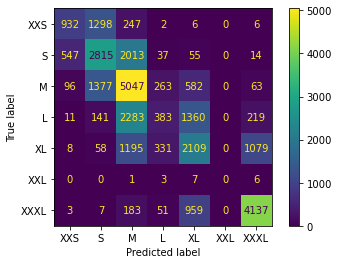

In [355]:
ConfusionMatrixDisplay.from_estimator(lr, X_test_ss, y_test, labels=hue_order);

The model achieves only 52% accuracy. When we did out EDA, we noticed a lot of overlap in the weight, height, and age across all sizes, therefore this result is not surprising. 

One explanation could be that people with similar bodies may have different taste regarding fit. Some prefer tighter fit, others prefer a looser fit. Another reason for our observation is that people of the same height and weight can have different body shapes which can greatly influence size. Depending on shape, some may carry more weight on their tops, bottoms, or mid-sections, thereby causing them to wear different sizes. 

Despite only achieving 52% accuracy, we can see that most errors occur withing neighboring sizes. This model can still provide shoppers with good size suggestions if we ask (1) their body type, and (2) their prefferred fit (form-fitting, normal, or loose).

### Predictions and their 'probabilities'

In [356]:
y_pred = pd.Series(lr.predict(X_test_ss))

y_proba = lr.predict_proba(X_test_ss)

maximums = pd.Series(np.amax(y_proba, axis=1))

predictions = pd.concat([y_pred, maximums], axis=1)

predictions.rename(columns={0: 'size', 1:'probability'}, inplace=True)

predictions.head()

,size,probability
0,M,0.345810
1,S,0.473477
2,XXS,0.498156
3,S,0.448677
4,M,0.411072


Mapping predictions to their probabilities can he helpful in determining which suggestions we should provide consumers. In cases where the probability of the size is say less than .25, we could choose to suggest either a size up or down depending on customer's body type. 

### Example of providing predictions

In [359]:
d = {'weight':[56], 'age': [34], 'height': [157.48], 'bmi': [22.7]}
Me = pd.DataFrame(data=d)
Me = pd.DataFrame(ss.transform(Me), columns=Me.columns)

In [360]:
lr.predict(Me)[0]

'M'

## Final Thoughts 

In this project, we imputed the data using KNNImputer, we also scaled the data using StandardScaler. Furthermore, after the EDA revealed the importance of weight and height in size determination, we also added BMI. 

We ran a few classification algorithms including: LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, BaggingClassifier and AdaBoost. Comparing results across these models, we obtained the best results from the logistic regression model, which we further fine-tuned using GridSearchCV. 

The final model resulted in an accuracy score of 52%, which upon first impression may not seem impressive. However, exploring the predictions and errors, we see that most errors are within neighboring sizes. This is not surprising, given that a lot of the data on weight, heigh, and age had overlap in across the sizes. Meaning many individuals who weighted, 75kg for instance wore size S, some size M, etc. Another reason why this is not a surprising result is that the data set does not imclude important information, such as fit preference and body shape. 

Nonetheless, this predictions can be useful in providing shoppers with suggestions. For instance, we can use this predictions to suggest size after a shopper had provided their preference for fit, if they would like a snug fit, we can provide a suggestions for a smaller size when the probability of the size and one size lower are withing a certain margin. Same for shoppers who want a loose fit, we can use these predictions to predict the correct size up. 
